Last updated as at 11 June 2017

In [416]:
import pandas as pd
import numpy as np
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
%matplotlib inline

# Linear regression with one variable

The first problem of the assignment considers the case of only one feature.

In [417]:
data = pd.read_csv("ex1data1.txt", header=None, names = ["Population", "Profit"])
data.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


## Visualizing the Data

In [418]:
datapts = go.Scatter(x = data["Population"], y=data["Profit"], mode = "markers",
                hoveron = "points")

plotly.offline.iplot({
    "data": [datapts],
    "layout": go.Layout(title="Relationship between Population and Profit", xaxis = dict(title="Population of City in 10,000s"), 
                     yaxis = dict(title="Profit in $10,000s"))
})

## Cost Function and Gradient Descent

In order to accomodate the error term, $\theta_0$, we need to add an additional "feature" $x_0$ which is defined to always be $x_0 = 1$.

In [419]:
feat0 = np.ones(len(data.index)) # 0th feature is always defined as a constant 1
feat1 = np.array(data["Population"]) # 1st feature

We want to represent hypothesis function to be in matrix form:

$h_{\theta}(X) = X  \theta$

where $X$ is a 97 by 2 matrix with the first column containing the zeroth features, $x^{(i)}_0$ and the second column containing the first feature, population, $x^{(i)}_1$, and $\theta$ is a 2 by 1 vector containing $\theta_0$ in the first row and $\theta_1$ in the second row.

In this way, we can vectorize our cost function $J$ and eliminate the need for a loop to implement the $\sum$ sum. This requires us to ensure that vector of target values, $y$ is shaped a 97 by 1 vector.

Note that number of data rows we have in this case is 97.

In [420]:
X = np.matrix([feat0,feat1] ).T
y = np.array(data["Profit"]).reshape(len(data.index),1)
theta_init = np.zeros((2,1))
X[0:5]

matrix([[ 1.    ,  6.1101],
        [ 1.    ,  5.5277],
        [ 1.    ,  8.5186],
        [ 1.    ,  7.0032],
        [ 1.    ,  5.8598]])

In [421]:
def compute_cost(X, y, theta):
    return (1/(2*len(y))) * np.sum(np.square((X*theta) - y))

For the given $X$ and $y$ from our training dataset and the initial values of $\theta_0=0, \theta_1=0$, the cost function equals to $J(\theta) = 32.07$.

In [422]:
print(compute_cost(X,y, theta_init))

32.0727338775


### Gradient Descent function

This function is designed to return not only the optimum $\theta$, but also two lists recording the values of $J(\theta)$ and $\theta$ at every iteration.

#### Some implementation notes for `gradient_descent_univariate()` function

Once we have completed the first iteration, we begin checking whether the cost has increased from previous iteration to the current iteration, and print a warning of any instance of that. We will not break the iteration or end the loop because we may want to also conduct experiments varying the learning rate $\alpha$ to visualize instances when cost explodes rather than minimize, and the values of $\theta$ associated with that.



In [423]:
def gradient_descent_univariate(X, y, theta, alpha, niter):
    J_history = []
    # Prepare a matrix that will hold the history of theta values
    theta_history = theta
    # Compute and append cost to J_History once before the start of the
    # loop in order to store the cost at the initialization values of theta
    J_history.append(compute_cost(X,y,theta))
    i = 0
    while(i<niter):
        # Indexing with a negative value on a list is equivalent
        # to indexing the first element, ie. J_history[0] == J_history[-1]
        if(J_history[i] > J_history[i-1]):
            print("Cost increased from iteration %d to %d"%(i-1, i-2))
        temp0 = theta[0] - (alpha/len(y)) * np.sum(X*theta - y)
        temp1 = theta[1] - (alpha/len(y)) * np.sum((X*theta - y).T*X[:,1:]) # Index all columns in X starting from the second column (right after the columns of all 1s)
        # Append the latest newly computed theta values to the history matrix
        theta_history = np.append(theta_history, 
                                  np.array([temp0,temp1]).reshape(2,1),
                                  axis = 1)
        theta[0] = temp0
        theta[1] = temp1
        J_history.append(compute_cost(X,y,theta))        
        i = i+1
        
    return theta, theta_history, J_history
    

In [424]:
iterations  = 1500
alpha = 0.01
theta_optimum, theta_history, J_history = gradient_descent_univariate(X,y,theta_init,alpha,iterations)

## Visualize the results

First, we plot the regression line together with the training data to assess the fit visually. Next we examine the properties of the cost function, $J(\theta)$, by visualizing its suface and countour plots. Lastly, I go one step further than what is required in the programming exercise, by making use of the `theta_history` and `J_history` arrays, to visualize the "optimisation trajectory" taken by the gradient descent algorithm.

### Regression Line

In [425]:
# Range of population values
pop_range = np.linspace(start=data["Population"].min(), stop =data["Population"].max(),
            num = 500)
# Matrix of input to hypothesis function
h_in = np.matrix([np.ones(500),pop_range]).T
profit_predicted = h_in*theta_optimum


In order to work, all arrays passed into `go.Scatter` must be flat arrays, so `profit_predicted` in its original form as a `np.matrix` must be converted to a flat `np.ndarray`. Initially I thought this could be accomplished with `np.asarray(profit_predicted).T`. I was very surprised when it failed to produce the line in the plot, and then realized that I overlooked a small difference in the array and that it was not really flattened as what I imagined. After a helpful reply to my post on the [Plotly forum](https://community.plot.ly/t/unable-to-generate-a-line-trace-together-with-a-scatter-trace-in-the-same-figure/4449/2), I realized that I should have called `flatten()` to be certain to flatten the array. Upon making this correction, the line showed up.

In [426]:
datapts = go.Scatter(x = data["Population"], y=data["Profit"], mode = "markers",
                hoveron = "points", name = "Training Data")
reg_line = go.Scatter(x = pop_range, y = np.asarray(profit_predicted).flatten(), mode = "lines",
                     hoveron="points", name= "Linear Regression")

plotly.offline.iplot({
    "data": [datapts,reg_line],
    "layout": go.Layout(title="Relationship between Population and Profit", 
                        xaxis = dict(title="Population of City in 10,000s"), 
                        yaxis = dict(title="Profit in $10,000s"))
})

### Surface and Contour Plots

Next, we visualize the cost function $J(\theta)$ using a surface and a contour plot.

In [427]:
theta0vals = np.linspace(start=-10,stop = 10,num=100)
theta1vals = np.linspace(start=-1,stop = 4,num=100)
m = np.zeros((len(theta0vals), len(theta1vals)))
for i in range(0, len(theta0vals)):
    for j in range(0, len(theta1vals)):
        m[i,j] = compute_cost(X, y, np.array([theta0vals[i],theta1vals[j]]).reshape(2,1))

In [428]:
costsurf = go.Surface(z = m, x=theta0vals, y=theta1vals)
plotly.offline.iplot({
    "data": [costsurf],
    "layout" : go.Layout(title="Surface Plot of Cost Function")
})
#TODO: Use Latex in the title once the issue is fixed of offline plotting
# https://stackoverflow.com/questions/34500906/in-plotly-python-api-how-to-enable-latex-rendering-in-offline-mode
# https://github.com/plotly/plotly.py/issues/105

In [429]:
contmap = go.Contour(z = m, x=theta0vals, y=theta1vals, 
                colorscale='Jet', contours = dict(coloring='heatmap'))
plotly.offline.iplot({
    "data": [contmap],
    "layout" : go.Layout(title = "Contour Plot of Cost Function")
})

### Optimization Trajectory

I also realized that it makes sense to do a 3D line plot visualizing how $J(\theta)$ varies as $\theta_0, \theta_1$ were updated during gradient descent actually computed it out. This line visualizes the path that was traversed along the cost surface during the execution of the gradient descent algorithm.

In the plot below, I removed the initialization values of $\theta_0, \theta_1 = 0$, since at this intial point, the cost was very large compared to the next first iteration. Including them would cause the plot to look very small. Just focussing on the smaller subsequent cost values, and we are able to see the parabolic trajectory.

$\theta_0$ is plotted along the x axis, and $\theta_1$ is plotted along the y axis.

In [430]:
descent_trajectory = go.Scatter3d(z = J_history[1:], x = theta_history[0,1:], y = theta_history[1,1:],
                mode="lines")
plotly.offline.iplot({"data":[descent_trajectory],
                      "layout": go.Layout(title = "Trajectory taken by the Cost Value during Gradient Descent")})

# Linear regression with multiple variables

The second part of the assignment considers the case of two features, but also expects implementations that are general enough to scale to any number of features.

In [431]:
data = pd.read_csv("ex1data2.txt", header = None, names=["Size", "Bedrooms","Price"])
data.head()

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


## Visualize the data

There are two features that we will now use to predict the price of a house: (1) size of the house (in square feet) and (2) number of bedrooms. We can observe that there is a linear trend in the data.

In [432]:
#TODO: beautify the plot
m = go.Scatter3d(z=data["Price"], x=data["Size"], y=data["Bedrooms"], mode="markers")
plotly.offline.iplot({"data":[m], 
                      "layout" : go.Layout(title = "House Prices against Size and Number of Bedrooms")})

## Feature Normalization

Purpose of feature scaling is to allow gradient descent to converge much faster than without it. It does not modify the linear relation of the data at all, so the visualization after features are scaled looks exactly the same as before, except for the values on the x and y axes. Each feature is scaled according to: 
    
$$\frac{x^{(i)}_j - \mu_j}{\sigma_j}$$



In [433]:
means = data.mean(0)
stdev = data.std(0)
data["Size Normalized"] = (data["Size"] - means["Size"])/stdev["Size"]
data["Bedrooms Normalized"] = (data["Bedrooms"] - means["Bedrooms"])/stdev["Bedrooms"]
data.head()

,Size,Bedrooms,Price,Size Normalized,Bedrooms Normalized
0,2104,3,399900,0.130010,-0.223675
1,1600,3,329900,-0.504190,-0.223675
2,2400,3,369000,0.502476,-0.223675
3,1416,2,232000,-0.735723,-1.537767
4,3000,4,539900,1.257476,1.090417


### Setting up our hypothesis

Similar to how we represented our hypothesis in a matrix form, we extend this style to construct our matrix for the multivariate case.

In [434]:
feat0 = np.ones(len(data.index))
feat1 = np.array(data["Size Normalized"])
feat2 = np.array(data["Bedrooms Normalized"])
theta_init = np.zeros((3,1))
y = np.array(data["Price"]).reshape(len(data.index),1)
X = np.matrix([feat0,feat1,feat2]).T
X[0:5]

matrix([[ 1.        ,  0.13000987, -0.22367519],
        [ 1.        , -0.50418984, -0.22367519],
        [ 1.        ,  0.50247636, -0.22367519],
        [ 1.        , -0.73572306, -1.53776691],
        [ 1.        ,  1.25747602,  1.09041654]])

In [435]:
# the original cost calculation function also works for multivariate cases
compute_cost(X,y,theta_init)

65591548106.457443

## Gradient Descent for the Multivariate Case

Extended the original gradient descent algorithm to support any number of features, $n$. This was achieved through the use of an inner for loop that computes the value of each parameter $\theta_0, \theta_1 \dots \theta_n$, storing the results in a temporary vector variable which is later used to perform the update to all parameter values in a single assignment.

In [436]:
def gradient_descent_multivariate(X, y, theta, alpha, niter):
    theta_temp = np.zeros((len(theta), 1))
    i = 0
    J_hist = []
    J_hist.append(compute_cost(X,y,theta))
    while(i<niter):
        # For loop iterates over each feature, updating each respective parameter separately
        for j in range(0, len(theta)):
            theta_temp[j] = theta[j] - (alpha/len(y)) * sum((X*theta - y).T * X[:,j]) 
        # Update our paramter values before proceeding on with the next iteration
        theta = theta_temp 
        J_hist.append(compute_cost(X,y,theta))
        i = i+1
    return theta, J_hist
# TODO: Think of a more vectorized way to write the code to eliminate the need for the for loop that iterates
# over each feature. Possible soln is to use Numpy broadcasting. 

In [437]:
iterations  = 1500
alpha = 0.01
theta_optimised, J_hist = gradient_descent_multivariate(X,y,theta_init,alpha,iterations)

### Convergence of gradient descent

We see that for the given learning rate of $\alpha = 0.01$ in the multivariate case, the does converge to a small value. It however does not go to zero. That is still correct because we do not have perfect linear fit to our data in this case (and this is true in many real world cases). It is not a requirement for the cost function in linear
regression gradient descent to converge to zero in order for the regression to have converged correctly.

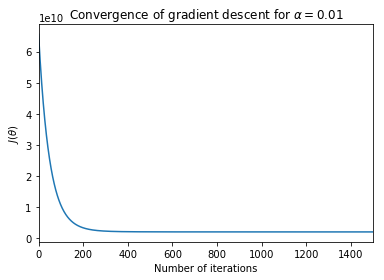

In [438]:
fig = pd.Series(J_hist).plot(title= "Convergence of gradient descent for $\\alpha = 0.01$")
fig.set_xlabel("Number of iterations")
fig.set_ylabel("$J(\\theta)$")

In [439]:
theta_optimised

array([[ 340412.56301439],
       [ 110542.36877135],
       [  -6560.9844688 ]])

## Visualization of the results

In this multivariate case with the dataset having two features, the regression results no longer is a line, but forms a plane in 3D space. That's because the two input features together form an area in a 2D plane where each point in the plane represents a combination of the 2 feature values, and each combination needs to be mapped to one output value,  the price, as predicted by the hypothesis function.

#### Computing the data needed to plot the regression plane

We start with a range of evenly spaced bedroom and size values that span the range of the dataset, normalize each feature value, and then compute the predicted price.

In [440]:
# Range of bedroom values
bedroom_range = np.linspace(start=data["Bedrooms"].min(), stop =data["Bedrooms"].max(),
            num = 100)
# Range of Size values
size_range = np.linspace(start=data["Size"].min(), stop =data["Size"].max(),
            num = 100)

Perform feature normalization...

In [441]:
bedroom_range_norm = (bedroom_range - means["Bedrooms"])/stdev["Bedrooms"]
size_range_norm = (size_range - means["Size"])/stdev["Size"]

In [442]:
price_predicted = np.zeros((len(size_range_norm), len(bedroom_range_norm)))

for i in range(0, len(size_range_norm)):
    for j in range(0, len(bedroom_range_norm)):
        price_predicted[i,j] = np.sum(theta_optimised[0] + theta_optimised[1]*size_range_norm[i]+theta_optimised*bedroom_range_norm[j])
        #print(np.sum(theta_optimised[0] + theta_optimised[1]*size_range_norm[i]+theta_optimised*bedroom_range_norm[j]))

### Visualize the regression results as a plane together with the training data

The initial orientation of the regression plane is angled such that the it is not visible. Use your mouse to rotate the plot in order to see the regression plane.

In [443]:
scatterdata = go.Scatter3d(z=data["Price"], x=data["Size"],
                           y=data["Bedrooms"], mode="markers", 
                           name = "Training Data")
reg_plane = go.Surface(z=price_predicted, x = size_range, y= bedroom_range, 
                       name = "Regression Plane")
plotly.offline.iplot({"data":[scatterdata,reg_plane], 
                      "layout": go.Layout(title="House Prices against Size and Number of Bedrooms")})

Is my result correct? I feel like the fit to the data is actually quite poor especially at larger bedrooms and larger sizes... it over estimates the price...post to coursera forums once the course is running to get feedback....

TODO: Complete the optional exercises using the Normal Equations